# Twitter Sentiment Classification

Data url: https://www.kaggle.com/c/tweet-sentiment-extraction/data  

Data summary: We have 22463 tweets labelled as Positive, Neutral or Negative.

There is an in progress Kaggle competition aimed at extracting phrases that highlight particular sentiment in a tweet. Given a tweet and the sentiment (positive, neutral, negative), participants need to identify the part of the tweet that defines that sentiment.


I have repurposed the dataset for sentiment classification intially. So ignoring the phrase that highlights sentiment, let's build an algorithm that can accurately detect sentiment based on the text in a tweet.

Given this is a case study for which we do not know the business use, I have chosen to use accuracy as the evaluation metric.

The final model accuracy on the test set is 74%.

Method:

The approach will be to:

1. Load and clean the data
2. Perform initial analysis to understand, for example distribution training data
3. Text preprocessing
4. Build,compile and fit recurrent neural network.
5. Compare to using pretrained embedded layer from BERT
6. Test


In [1]:
pip install keras

In [2]:
from keras.optimizers import RMSprop

In [3]:
pip install transformers

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
!pip install --upgrade keras scikit-learn
!pip install scikeras
!pip install scikit-learn

In [6]:
import pandas as pd
import re
import numpy as np
# %pip install RMSprop
%pip install adam
import adam as adam

np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, GRU, Embedding
from keras.layers import Activation, Bidirectional, GlobalMaxPool1D, GlobalMaxPool2D, Dropout
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM, Dropout
#from tensorflow.keras.layers import concatenate

from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import seaborn as sns
# import transformers
from transformers import AutoTokenizer
from tokenizers import BertWordPieceTokenizer
from keras.initializers import Constant
#from scikeras.wrappers_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from collections import Counter

stop=set(stopwords.words('english'))


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [8]:
df = pd.read_csv('./train.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## 1. Load and Clean the Data

We drop the NaN values and have 4 helper functions to clean the data. These are:
1. basic_cleaning - to remove website urls, non-characters and to replace '*****' swear words with the word swear
2. remove_html
3. remove_emojis
4. remove_multiplechars - this is for when there are more than 3 characters in a row in a word e.g. wayyyyy. The function removes all but one of the letters

The data is then ready for initial exploration.

In [9]:
df.dropna(inplace=True)

In [10]:
#https://www.kaggle.com/shahules/complete-eda-baseline-model-0-708-lb

def basic_cleaning(text):
    text=re.sub(r'https?://www\.\S+\.com','',text)
    text=re.sub(r'[^A-Za-z|\s]','',text)
    text=re.sub(r'\*+','swear',text) #capture swear words that are **** out
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_multiplechars(text):
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    return text


def clean(df):
    for col in ['text']:#,'selected_text']:
        df[col]=df[col].astype(str).apply(lambda x:basic_cleaning(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_emoji(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_html(x))
        df[col]=df[col].astype(str).apply(lambda x:remove_multiplechars(x))

    return df

In [11]:
df_clean = clean(df)
df_clean.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,Id have responded if I were going,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego,Sooo SAD,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview leave me alone,leave me alone,negative
4,358bd9e861,Sons of why couldnt they put them on the rel...,"Sons of ****,",negative


## 2. Data Exploration



In this section we look at:
1. The distribution of number of tweets by sentiment:
The three groups of positive, neutral and negative are fairly well balanced

2. The distribution of length of tweet by sentiment:
The length of tweets, on visual inspection does not appear to be very different.

3. The most common words:
Like appears in the top 10 for all three groups. Given it's in all three groups, we will not remove it as it will still provide information within individual sequences.

In [12]:
shape = df_clean.shape
print(f"There are {shape[0]} tweets in the dataset")

There are 27480 tweets in the dataset


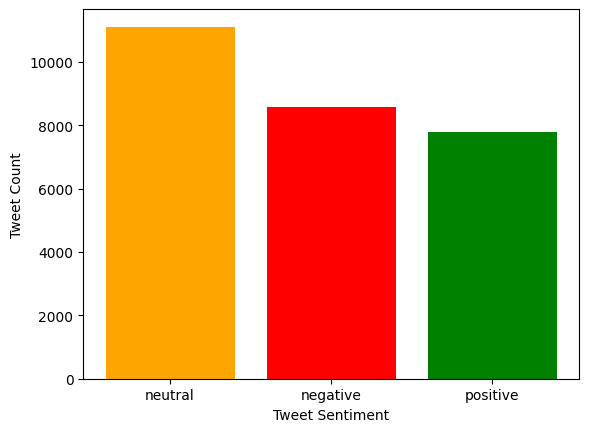

In [13]:
colors=['orange','red','green']
plt.bar(df.sentiment.unique(),df.sentiment.value_counts(), color=colors);
plt.xlabel('Tweet Sentiment');
plt.ylabel('Tweet Count');

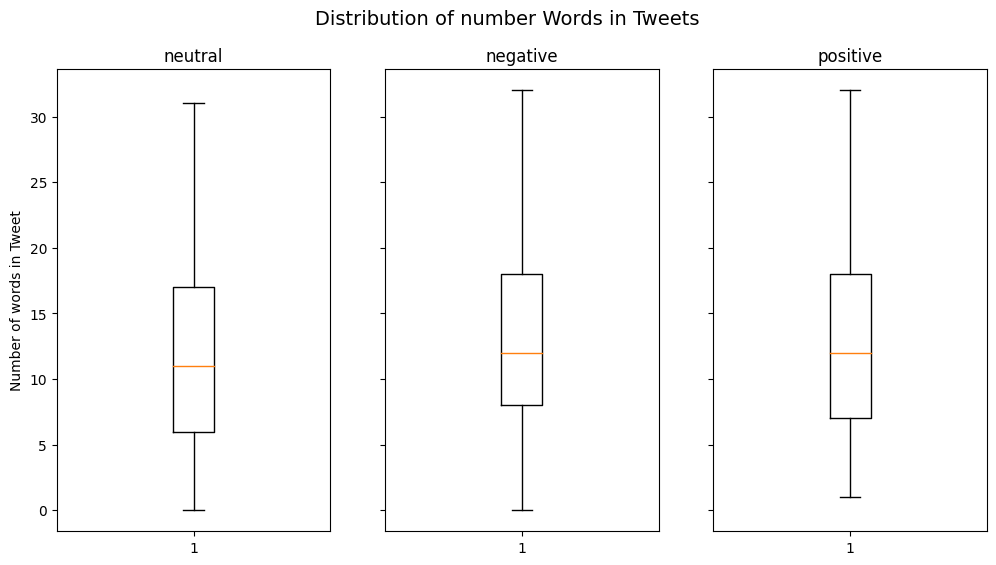

In [14]:
sent=df.sentiment.unique()
fig,ax= plt.subplots(1,3,figsize=(12,6),sharey=True)
for i in range(0,3):
    lengths = df_clean[df_clean['sentiment']==sent[i]]['text'].str.split().str.len()
    ax[i].boxplot(lengths)
    ax[i].set_title(sent[i])
ax[0].set_ylabel('Number of words in Tweet')
fig.suptitle("Distribution of number Words in Tweets", fontsize=14);

In [15]:
def preprocess_news(df,stop=stop,n=1,col='text'):
    '''Function to preprocess and create corpus'''
    new_corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for text in df[col]:
        words=[w for w in word_tokenize(text) if (w not in stop)]

        words=[lem.lemmatize(w) for w in words if(len(w)>n)]

        new_corpus.append(words)

    new_corpus=[word for l in new_corpus for word in l]
    return new_corpus

In [16]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Text(0.5, 0.98, 'Common words in tweet text')

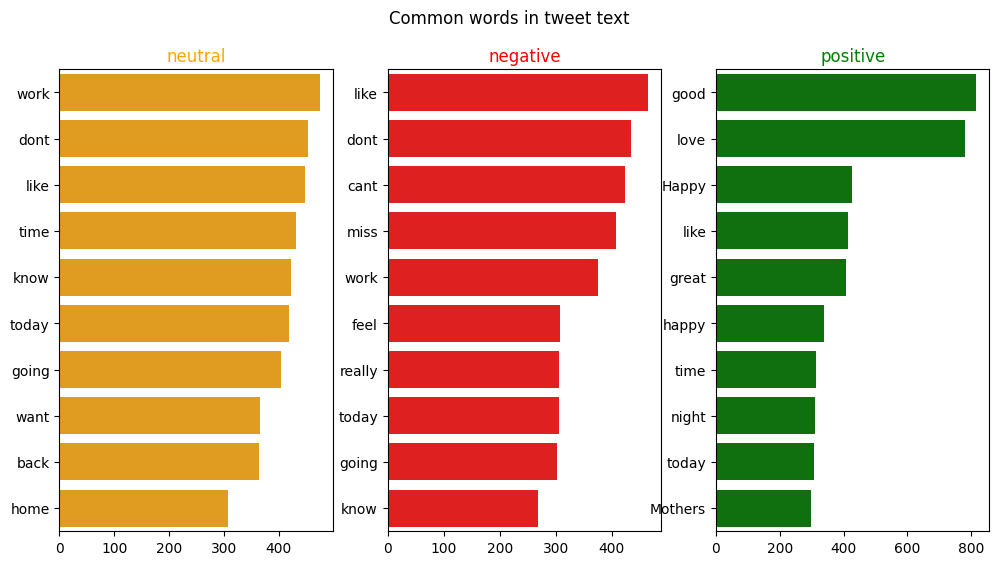

In [17]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

fig,ax=plt.subplots(1,3,figsize=(12,6))
for i in range(3):
    new=df_clean[df_clean['sentiment']==sent[i]]
    corpus_train=preprocess_news(new,n=3)
    counter=Counter(corpus_train)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:10]:
        if (word not in stop) :
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x,ax=ax[i],color=colors[i])
    ax[i].set_title(sent[i],color=colors[i])
fig.suptitle("Common words in tweet text")

# Data Preprocessing

For the labels, one-hot encoding performed significantly better than LabelEncoder. We also tokenize and covert to sequences.

In [18]:
df_clean_selection = df_clean.sample(frac=0.2)
X = df_clean_selection.text.values
y = pd.get_dummies(df_clean_selection.sentiment)

In [19]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
X_t = pad_sequences(list_tokenized_train, maxlen=128)

## Model Building and Training

For the classification model, we build a recurrent neural network (RNN) with two Long, Short Term Memory (LSTM) layers.

Initial performance indicated two LSTM layers performed slightly better than one. We use birectional layers to take advantage of the fact that some further semantic information can be gained from cycle through the tweets backwards. We have two dropout layers to prevent overfitting and a dense layer with L1L2 regularization.

We then:

1. Perform gridsearch for the best optimizer of gradient descent
2. Perform gridsearch for the best learning rate

Note: GridSearch CV is not optimized for GPU, so we are using pure Keras and manual gridsearch.   
Note: In the interests of time, parameter selection was performed on a random sample of 25% of the training data.

In [20]:
def create_model():
    embedding_size = 128
    input_ = Input(shape=(128,))
    x = Embedding(20000, embedding_size)(input_)
    x = Bidirectional(LSTM(50,return_sequences=True))(x)
    x = Bidirectional(LSTM(25,return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(50, activation='relu', kernel_regularizer='L1L2')(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)

    model = Model(inputs=input_, outputs=x)
    return model

#model = KerasClassifier(create_model)

In [21]:
optimizers_names = ['SGD', 'RMSprop', 'Adam']
model = create_model()


In [22]:
for optim in optimizers_names:

    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    history = model.fit(X_t,y,batch_size=32,epochs=2,validation_split=0.1)


Epoch 1/2
155/155 [==============================] - 22s 63ms/step - loss: 1.0903 - accuracy: 0.4001 - val_loss: 1.0881 - val_accuracy: 0.4145
Epoch 2/2
155/155 [==============================] - 4s 23ms/step - loss: 1.0859 - accuracy: 0.4139 - val_loss: 1.0863 - val_accuracy: 0.4145
Epoch 1/2
155/155 [==============================] - 19s 74ms/step - loss: 1.0858 - accuracy: 0.4121 - val_loss: 1.0833 - val_accuracy: 0.4145
Epoch 2/2
155/155 [==============================] - 5s 32ms/step - loss: 1.0448 - accuracy: 0.4511 - val_loss: 0.9250 - val_accuracy: 0.5509
Epoch 1/2
155/155 [==============================] - 22s 85ms/step - loss: 0.8754 - accuracy: 0.5906 - val_loss: 0.8103 - val_accuracy: 0.6545
Epoch 2/2
155/155 [==============================] - 5s 35ms/step - loss: 0.6424 - accuracy: 0.7380 - val_loss: 0.8636 - val_accuracy: 0.6382


In [23]:
from keras.optimizers import Adam

In [24]:
learning_rate = [0.001,0.01,0.1]

for rate in learning_rate:
    Adam_name = Adam(lr=rate)
    model.compile(loss='categorical_crossentropy',optimizer=Adam_name,metrics=['accuracy'])
    history = model.fit(X_t,y,batch_size=32,epochs=2,validation_split=0.1)

Epoch 1/2
155/155 [==============================] - 22s 92ms/step - loss: 0.4401 - accuracy: 0.8449 - val_loss: 0.9700 - val_accuracy: 0.6509
Epoch 2/2
155/155 [==============================] - 5s 32ms/step - loss: 0.2747 - accuracy: 0.9151 - val_loss: 1.2940 - val_accuracy: 0.6236


Epoch 1/2
155/155 [==============================] - 22s 85ms/step - loss: 0.2244 - accuracy: 0.9290 - val_loss: 1.3344 - val_accuracy: 0.6236
Epoch 2/2
155/155 [==============================] - 7s 46ms/step - loss: 0.1420 - accuracy: 0.9590 - val_loss: 1.4446 - val_accuracy: 0.6382


Epoch 1/2
155/155 [==============================] - 20s 82ms/step - loss: 0.1169 - accuracy: 0.9656 - val_loss: 1.7135 - val_accuracy: 0.5945
Epoch 2/2
155/155 [==============================] - 5s 32ms/step - loss: 0.0880 - accuracy: 0.9763 - val_loss: 1.7699 - val_accuracy: 0.6109


## Preprocessing, Model build and training with DistilBert

We now turn our attention to pretrained embeddings. In this case we download and use DistilBert instead of training our own Embedding layer. DistilBert, a light version of BERT, google's game-changing NLP model, provides us with a tokenizer and an embedding matrix. BERT base uncased is trained on lower case English text and has around 110 million parameters (768 dimensions for embedding each word, and a vocab of 143,000 words). Distilbert has 60% of this, but maintains 97% performance against BERT.

For the purposes of this example, we will leave that matrix rather than train it, as it's large and we would have unrealistic training times.

In [25]:
pip install transformers

In [26]:
import transformers as transformers

In [27]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")  ## change it to commit

# Save the loaded tokenizer locally
save_path = r'./distilbert-base-uncased'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer(r'./distilbert-base-uncased/vocab.txt', lowercase=True)
fast_tokenizer

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [28]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=128):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []

    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

In [29]:
X = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
X.shape

(5496, 128)

In [30]:
!rm -rf /content/distilbert-base-uncased
transformer_layer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [31]:
embedding_size = 128
input_ = Input(shape=(100,))

inp = Input(shape=(128, ))
#inp2= Input(shape=(1,))

embedding_matrix=transformer_layer.weights[0].numpy()

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],embeddings_initializer=Constant(embedding_matrix),trainable=False)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu', kernel_regularizer='L1L2')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_DistilBert = Model(inputs=[inp], outputs=x)

In [32]:
model_DistilBert.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
model_DistilBert.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 128, 768)          23440896  
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 100)          327600    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 50)           25200     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                           

In [34]:
y

,negative,neutral,positive
20673,0,0,1
12581,0,1,0
13136,0,0,1
14013,0,0,1
25030,0,1,0
...,...,...,...
10340,1,0,0
3867,0,1,0
9813,1,0,0
16998,0,1,0


In [35]:
X

array([[  101,  7459,  1996, ...,     0,     0,     0],
       [  101,  3100,  2023, ...,     0,     0,     0],
       [  101, 15854,  7570, ...,     0,     0,     0],
       ...,
       [  101, 26927, 10649, ...,     0,     0,     0],
       [  101,  6289,  8445, ...,     0,     0,     0],
       [  101,  5262,  2172, ...,     0,     0,     0]])

In [36]:
model_DistilBert.fit(X,y,batch_size=32,epochs=2,validation_split=0.1)

Epoch 1/2
155/155 [==============================] - 12s 37ms/step - loss: 1.0938 - accuracy: 0.3858 - val_loss: 1.0866 - val_accuracy: 0.4145
Epoch 2/2
155/155 [==============================] - 3s 21ms/step - loss: 1.0872 - accuracy: 0.4108 - val_loss: 1.0790 - val_accuracy: 0.4145


## Test the Final DistilBert Model

In [37]:
df_clean_final = df_clean.sample(frac=1)
X_train = fast_encode(df_clean_selection.text.astype(str), fast_tokenizer, maxlen=128)
y_train = y

In [38]:
Adam_name = Adam(learning_rate=0.001)
model_DistilBert.compile(loss='categorical_crossentropy',optimizer=Adam_name,metrics=['accuracy'])
history = model_DistilBert.fit(X_train,y_train,batch_size=32,epochs=10)

Epoch 1/10
172/172 [==============================] - 11s 21ms/step - loss: 1.0315 - accuracy: 0.4652
Epoch 2/10
172/172 [==============================] - 6s 32ms/step - loss: 0.9186 - accuracy: 0.5488
Epoch 3/10
172/172 [==============================] - 3s 19ms/step - loss: 0.8571 - accuracy: 0.5970
Epoch 4/10
172/172 [==============================] - 3s 19ms/step - loss: 0.7638 - accuracy: 0.6656
Epoch 5/10
172/172 [==============================] - 3s 20ms/step - loss: 0.7158 - accuracy: 0.7020
Epoch 6/10
172/172 [==============================] - 5s 27ms/step - loss: 0.6646 - accuracy: 0.7222
Epoch 7/10
172/172 [==============================] - 5s 28ms/step - loss: 0.6386 - accuracy: 0.7407
Epoch 8/10
172/172 [==============================] - 3s 19ms/step - loss: 0.6200 - accuracy: 0.7498
Epoch 9/10
172/172 [==============================] - 4s 23ms/step - loss: 0.5845 - accuracy: 0.7636
Epoch 10/10
172/172 [==============================] - 4s 24ms/step - loss: 0.5639 - accur

In [39]:
df_test = pd.read_csv('test.csv')
df_test.dropna(inplace=True)
df_clean_test = clean(df_test)

X_test = fast_encode(df_clean_test.text.values.astype(str), fast_tokenizer, maxlen=128)
y_test = df_clean_test.sentiment

In [40]:
y_preds = model_DistilBert.predict(X_test)
y_predictions = pd.DataFrame(y_preds, columns=['negative','neutral','positive'])
y_predictions_final = y_predictions.idxmax(axis=1)
accuracy = accuracy_score(y_test,y_predictions_final)
print(f"The final model shows {accuracy:.2f} accuracy on the test set.")

111/111 [==============================] - 2s 9ms/step
The final model shows 0.73 accuracy on the test set.
